# WGAN-GP DNA Generation

## Imports

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim, autograd

from datasets.ChrDataset import Chr1Dataset, Chr1DevDataset
from models.Discriminator import Discriminator
from models.Generator import Generator
from models.WGANGP import WGANGP
from trainers.wgan_gp_trainer import WGANGPTrainer
from evaluators.wgan_gp_evaluator import WGANGPEvaluator
from utils.sequence_utils import *

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CHR1 Data Loading and preprocessing

In [2]:
# Set the random seeds for reproducability
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [3]:
torch.cuda.set_device(0)

In [4]:
def chr1_data():
    """ Function to load both the train and test datasets of Chromosome1.
    Returns a tuple of both datasets.
    """
    out_dir = './data/chr1'
    train_data = Chr1Dataset(root_folder=out_dir, train=True, sequence_size=50)
    test_data = Chr1Dataset(root_folder=out_dir, train=False, sequence_size=50)
    return train_data, test_data

try:
   del train_data
   del test_data
   print('Clear previously loaded data.')
except:
   pass

train_data, test_data = chr1_data()

In [5]:
# Visualize dimensions and number of instatnces
print("Number of train data sequences:", len(train_data))
print("Shape first train sequence one hot:",train_data[0].shape)

print("Number of test data before split into test-valid sequences:", len(test_data))
print("Shape fisrt test sequence one hot:",test_data[0].shape)


Number of train data sequences: 3687696
Shape first train sequence one hot: torch.Size([50, 4])
Number of test data before split into test-valid sequences: 921924
Shape fisrt test sequence one hot: torch.Size([50, 4])


In [6]:
# Split test data to validation and test set. Note that this should be deterministic with seed = 1234
test_set_size = len(test_data)
test_length = int(0.5 * test_set_size)
validation_len = test_set_size - test_length

# Torch's seed comes into play in this line!
test_data, validation_data = torch.utils.data.dataset.random_split(test_data, lengths=[test_length, validation_len])

In [7]:
print("Number of test data sequences:", len(test_data))
print("Number of validation data sequences:", len(validation_data))

Number of test data sequences: 460962
Number of validation data sequences: 460962


In [8]:
from torch.utils.data import sampler, DataLoader

# We now make a data loader for the validtaion set, that submsamples from it. We don't need a whole
# lof of validation here.
num_validation = len(validation_data)
num_batches = 100
batch_size = 128
# Define a subsampler for the last 100 batches of validation data set.
sampler = sampler.SubsetRandomSampler(range(num_validation - batch_size * num_batches, num_validation))

In [9]:
validation_data_loader = DataLoader(validation_data,
                    batch_size=batch_size,
                    sampler=sampler)

In [10]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=128,
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=4)

In [11]:
print("number of training batches ", len(train_data_loader))
print("number of validation batches ", len(validation_data_loader))

number of training batches  28810
number of validation batches  100


## Training

In [ ]:
# Both generator and discriminator could be any nn, as long as generator exposes latent_dim variable.
discriminator = Discriminator(conv_dim=100, seq_length=50)
generator = Generator(latent_dim=100, conv_dim=100, seq_length=50)

# Note that turninig our WGANGP object to cuda turns both discriminator and generator to .cuda as they are child models.
wgan_gp = WGANGP(discriminator=discriminator, generator=generator).cuda()

# If want to log_tbx, TensorBoardX must be up and running.
trainer = WGANGPTrainer(wgan_gp,
                        train_data_loader=train_data_loader,
                        validation_data_loader=validation_data_loader,
                        should_log_tbx=False,
                        evaluate_every=200,
                        experiment_name='latent_space_test',
                        num_epochs=1,)

trainer.train()

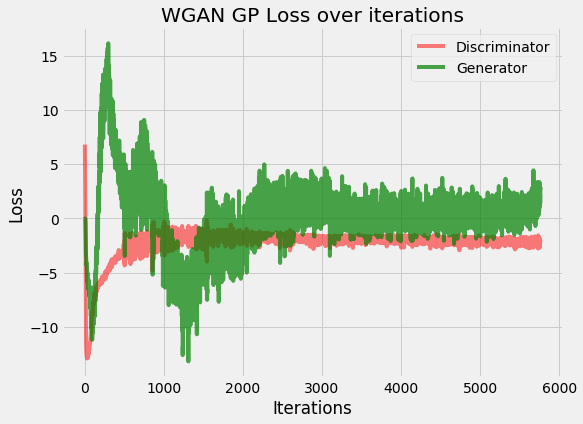

In [17]:
trainer.plot_loss()

In [ ]:
gan = wgan_gp
gan.eval()

In [35]:
# Sample batch of 10 vectors from latent space
batch_of_latent = to_cuda(torch.randn(10, 100))

# Generate Sequences
generated_sequence = gan.generator(batch_of_latent)

for i in range(10):
    print("Generated Sequence %d: %s" % (i+1, one_hot_to_seq(test_seq[i].max(dim=1)[1])))

Generated Sequence 1: attaacaacctggcacagctactgcacaatataaaggggtaggcctctat
Generated Sequence 2: ttttgttctggaacctggctcagaagtctttttggggagagacaaaatat
Generated Sequence 3: aggatctttctgccaaattctttgccagaggtgcaattcctaggtgttct
Generated Sequence 4: gacagcttcctgacaaagacaaagatagctgagcctggaaagaaagcaat
Generated Sequence 5: acaaacaaatttagcagtgaactggagaaggagcagtgaaattaaataat
Generated Sequence 6: ataatactcttacaagacaaatctccatgaagaaataacacagcttggat
Generated Sequence 7: ctcagacttattctttgaatgtcagaacaaactataaaaaaaatgcaggg
Generated Sequence 8: gtgccctggtctctgttttgtttcttttaacaagcacacaccagaaaaga
Generated Sequence 9: gtggaaatgaggcactgtgtataataaatttaaaattttccactctttta
Generated Sequence 10: atcttcttacagtataggacataatatatgagggtaagcagatgttcagt


## Analyze Kmer proportions

In [19]:
%matplotlib inline
from IPython.core.pylabtools import figsize

plt.style.use('seaborn-deep')

def draw_histogram_for_k(k):
    figsize(12, 10)

    sorted_keys = sorted(trainer.evaluator.real_kmer_model[k]._kmer_counts.keys())
    generated = [trainer.evaluator.kmer_proportions_history[k][-1][key] for key in sorted_keys]
    real = [trainer.evaluator.real_kmer_model[k]._kmer_counts[key] for key in sorted_keys]

    x = np.array(real)
    x = x / np.sum(x)

    y = np.array(generated)
    y = y / np.sum(y)

    ind = np.arange(4**k)  # the x locations for the groups
    width = 0.35       # the width of the bars


    ax = plt.subplot(2, 2, k + 1)
    real = ax.bar(ind, x, width, color='magenta', alpha=0.5)
    generated = ax.bar(ind + width, y, width, color='b', alpha=0.5)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Frequency')
    ax.set_title('Real and Generated')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(sorted_keys)

    ax.legend((real[0], generated[0]), ('real', 'generated'))
    plt.tight_layout()
    plt.show()

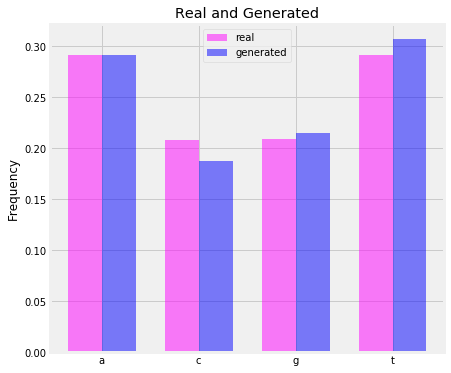

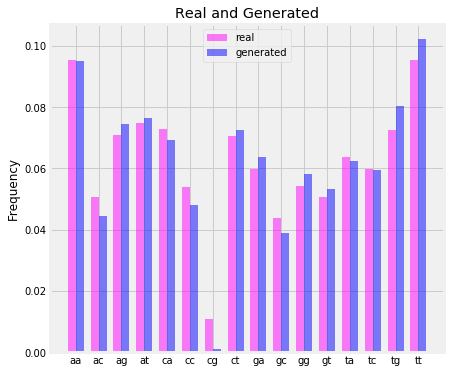

In [20]:
for k in [1,2]:
    draw_histogram_for_k(k)